## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# !pip install pytorch-nlp
# ! pip install nltk
# ! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

from nltk.translate.bleu_score import corpus_bleu
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9270
Unique tokens in target (en) vocabulary: 6678


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'горячий',
 'rio',
 'кур',
 'der',
 '110',
 'mundo',
 'фантастическим',
 'диетическое',
 'сфорца']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', '48', 'dame', 'cellars', 'nassau', 'syros', 'mestre']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['there', 'is', 'a', 'full', 'kitchen', 'with', 'a', 'microwave', 'and', 'oven', ',', 'and', 'the', 'bathroom', 'is', 'fitted', 'with', 'a', 'shower', 'and', 'a', 'washing', 'machine', '.'], 'src': ['кроме', 'того', ',', 'в', 'вашем', 'распоряжении', 'полностью', 'оборудованная', 'кухня', 'с', 'микроволновой', 'печью', 'и', 'духовкой', ',', 'а', 'также', 'ванная', 'комната', 'с', 'душем', 'и', 'стиральной', 'машиной', '.']}


Let's check the length distributions:

Length distribution in Train data


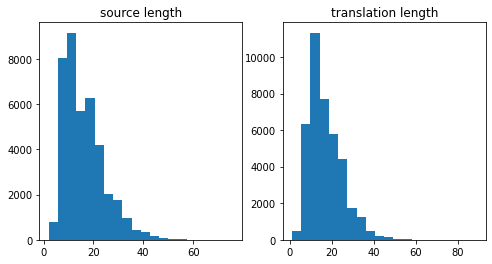

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


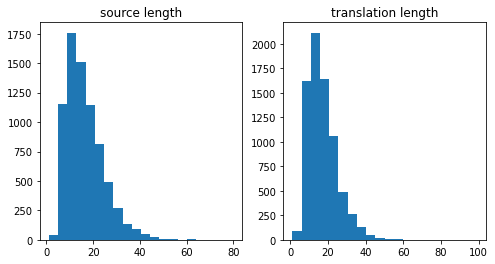

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

There are quite a lot of sentences with more than 20 words. As I remember from the lecture notes, after this point the quality of translations decreases unless the attention is used. That is why I suppose that the attention will result in big profit.

### Model side
I improved the baseline model by applying the following things:
- ReduceLROnPlateau(factor=0.3, patience=3)
- batch_size=64 (the less batch_size, the higher BLEU, compared with 128 and 256)
- Attention(attention_type='dot'). Used Pytorch NLP library with a IBM implementation of Attention. Quite simple (no multiplicative/additive approaches with additional weight matrices, just enough implementation)

Quite a basic approach but gives a great BLEU result.

Also, I tried to combine CNN (2-layers + 2 ReLUs + 1 BatchNorm) with Encoder's LSTM. However, the result was worse than with the above-written model configs.

You may see the results table at the end of the notebook.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
import my_network

Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9270, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6678, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=6678, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,389,206 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

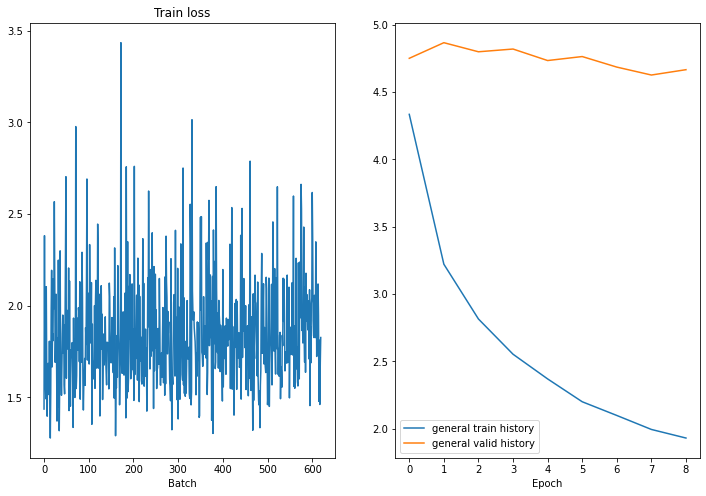

Epoch: 10 | Time: 2m 32s
	Train Loss: 1.842 | Train PPL:   6.307
	 Val. Loss: 4.757 |  Val. PPL: 116.393


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the motorway is nearby .
Generated: the is is next to the do sol .

Original: the property also offers grocery delivery .
Generated: the property also offers grocery delivery .



In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

118it [00:05, 21.25it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

30.806762073297243

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

### Results Table

|                                                     Model updates <br>(compared to baseline model)                                                     | Complexity <br>(# of training parameters) | Training time<br>per an epoch* | Quality<br>(in BLEU) | Comments                                                                                                                                                                                              |
|:------------------------------------------------------------------------------------------------------------------------------------------------------:|:-----------------------------------------:|:------------------------------:|:--------------------:|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|                                               ReduceLROnPlateau(factor=0.3, patience=5),<br> <br>epoch=20                                              |                 14,911,318                |          1 min 24 sec          |         17.97        | I suppose this is because of the <br><br>increase of # of epochs                                                                                                                                      |
|                                   ReduceLROnPlateau(factor=0.3, patience=4),<br><br>epoch=10,<br><br>Attention('dot')                                  |                 15,378,701                |          1 min 47 sec          |         28.37        | Decreased patience in the scheduler to react faster.<br><br>Attention gives a great improvement of BLEU.                                                                                              |
|                       ReduceLROnPlateau(factor=0.3, patience=3),<br><br>epoch=10,<br> <br>batch_size=64,<br> <br>Attention('dot')                      |                 15,378,701                |            2 min 30s           |         30.80        | The batch size has an impact on quality. I tried <br><br>batch_size=256 but it worsened the BLEU so making opposite<br><br>action (decreasing to 64) I found out that it improves the result.         |
| CNNEncoder(Conv1->ReLU->Conv2->ReLU->BatchNorm),<br><br>+ the same RNNEncoder,<br><br>epoch=10,<br><br>batch_size=64,<br><br>Attention(hid_dim, 'dot') |                 15,773,277                |          5 min 48 sec          |         28.14        | I didn't understand well how to use CNN in case of using Attention.<br><br>That is why I experimented combining the CNN model with <br><br>the usual RNN encoder but it didn't result in improvement. |

* The time may differ from real values because I used Google Colab and it sometimes gives a slow machine.